In [2]:
import random
import re
from collections import Counter
from itertools import groupby

import en_core_web_lg
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import wordninja
from networkx.algorithms.community import greedy_modularity_communities

from IPython.display import HTML
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

In [27]:
G = nx.read_gpickle('models/Thunderbirdsim.gpickle')

In [28]:
def log_transformer(pdoc):
    #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html
    countVec = CountVectorizer(max_features= 5000, stop_words='english', min_df=.01, max_df=.90)

    #%%
    #use CountVectorizer.fit(self, raw_documents[, y] to learn vocabulary dictionary of all tokens in raw documents
    #raw documents in this case will betweetsFrameWords["Text"] (processed text)
    countVec.fit(pdoc)
    #useful debug, get an idea of the item list you generated
    list(countVec.vocabulary_.items())

    #%%
    #convert to bag of words
    #sparse matrix representation? (README: could use an edit/explanation)
    countVec_count = countVec.transform(pdoc)

    #%%
    #make array from number of occurrences
    occ = np.asarray(countVec_count.sum(axis=0)).ravel().tolist()

    #make a new data frame with columns term and occurrences, meaning word and number of occurences
    bowListFrame = pd.DataFrame({'term': countVec.get_feature_names(), 'occurrences': occ})
    # print(bowListFrame)

    #sort in order of number of word occurences, most->least. if you leave of ascending flag should default ASC
    bowListFrame.sort_values(by='occurrences', ascending=False).head(60)

    #%%
    #now, convert to a more useful ranking system, tf-idf weights
    #TfidfTransformer: scale raw word counts to a weighted ranking using the
    #https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html
    logTransformer = TfidfTransformer()
    logTransformer.fit_transform(countVec_count)

    df_idf = pd.DataFrame(logTransformer.idf_,index=countVec.get_feature_names(),columns=["idf_weights"]) 
    # sort ascending 
    df_idf= df_idf.sort_values(by=['idf_weights'])
    # print (df_idf.head(30))
    return df_idf

TDIFD to connected compponents of graph to find relevant tags

The club has 58 communities.


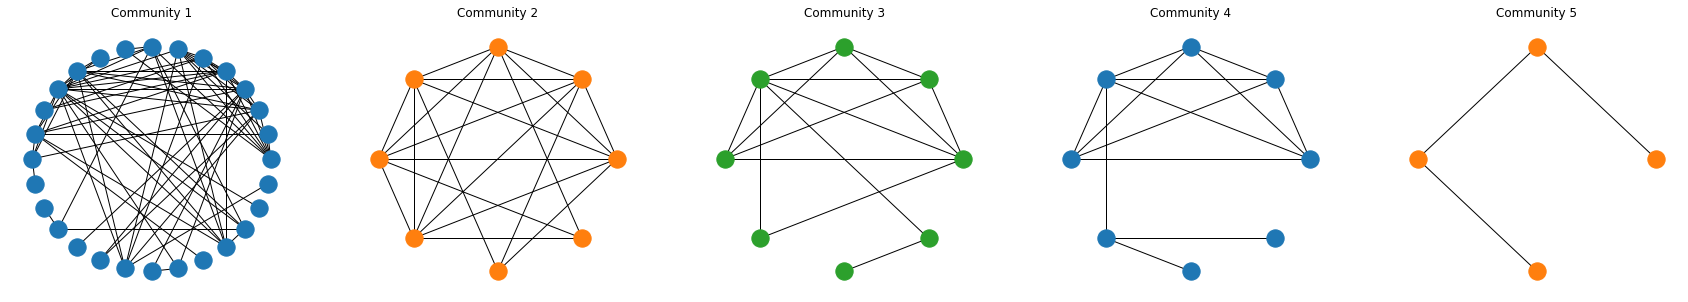

In [39]:
# Find the communities
import networkx.algorithms.community as nx_comm
communities = sorted(nx_comm.greedy_modularity_communities(G), key=len, reverse=True)

# Count the communities
print(f"The club has {len(communities)} communities.")

'''Add community to node attributes'''
for c, v_c in enumerate(communities):
    for v in v_c:
        # Add 1 to save 0 for external edges
        G.nodes[v]['community'] = c + 1

'''Find internal edges and add their community to their attributes'''
for v, w, in G.edges:
    if G.nodes[v]['community'] == G.nodes[w]['community']:
        # Internal edge, mark with community
        G.edges[v, w]['community'] = G.nodes[v]['community']
    else:
        # External edge, mark as 0
        G.edges[v, w]['community'] = 0



N_coms=len(communities)
edges_coms=[]#edge list for each community
coms_G=[nx.Graph() for _ in range(N_coms)] #community graphs
colors=['tab:blue','tab:orange','tab:green']*N_coms #colors for communities
fig=plt.figure(figsize=(30,5))

for i in range(5):
  edges_coms.append([(u,v,d) for u,v,d in G.edges(data=True) if d['community'] == i+1])#identify edges of interest using the edge attribute
  coms_G[i].add_edges_from(edges_coms[i]) #add edges
  plt.subplot(1,5,i+1)#plot communities
  plt.title('Community '+str(i+1))
  pos = nx.circular_layout(coms_G[i])
  nx.draw(coms_G[i],pos=pos,with_labels=False,node_color=colors[i]) 

In [60]:
print(coms_G[1].nodes())

['DHCP DISCOVER from <*> via eth <*><*>', 'DHCP <*> from <*> via eth <*>', 'connection from <*>', 'DHCP REQUEST for <*> from <*> via eth <*><*>', 'Received SNMP packet from <*>', 'START ftp pid <*> from <*>', 'DHCP <*> via eth <*>', 'User <*> coming from <*> authenticated']


In [62]:
S = [G.subgraph(c) for c in nx.connected_components(G)]  
print(len(S)  )
tags_cluster = []
nlp =en_core_web_lg.load()
for cluster in  coms_G:
    
    if len(cluster)> 3:
        df = log_transformer(list(cluster.nodes()))
        tags_list = dict(df.iloc[:,0]).keys()

        tags_list = nlp(' '.join(tags_list))
        tags_cluster =  [token.lemma_ for token in tags_list if token not in nlp.Defaults.stop_words]
        nx.set_node_attributes(cluster, tags_cluster , 'tags')

    else:
        string =' '.join (cluster.nodes())
        cleanString = re.sub('\W+',' ', string )
        doc = nlp(cleanString)
        tags_cluster = [token.lemma_ for token in doc if token not in nlp.Defaults.stop_words]
        nx.set_node_attributes(cluster, tags_cluster , 'tags')

print(coms_G[1].nodes['DHCP DISCOVER from <*> via eth <*><*>']['tags'])

52
['dhcp', 'eth', 'authenticate', 'come', 'connection', 'discover', 'ftp', 'packet', 'pid', 'receive', 'request', 'snmp', 'start', 'user']


Adding a new node using TFIDF

In [65]:
def remove_repeated(val):
  x = val.split(" ")
  str_list = list(filter(None, x))
  clean = [i[0] for i in groupby(str_list)]
  return ' '.join(clean)


def preprocess_document(document):
    dic_debug = {}
    # log_list =  [re.sub(r"[^A-Za-z]+", ' ', _) for _ in document]
    for log in document:
        splitted_log = wordninja.split(log)
        remove_urls = re.sub('[^ ]+\.[^ ]+','<*>',' '.join(splitted_log) )
        
        remove_float = re.sub("(\d*\.\d+)|(\d+\.[0-9 ]+)", "<*>", remove_urls) 
        remove_int = re.sub(r'\d+', "<*>", remove_float )
        generic_str = re.sub(r'\b\w{1,2}\b', '', remove_int) 

        dic_debug[log]  = remove_repeated(generic_str)
    logs_clean =dic_debug.values()
    return logs_clean

In [66]:
atrributes = Counter(list(G.nodes()))
nx.set_node_attributes(G, atrributes, "count")

In [68]:
def add_node_if_exist(G,node):
    relationship = []
    nodeset =(G.nodes())
    if node in nodeset:
        count = G.nodes[node]['count']
        print(node, G.nodes[node])
        count +=1
        print("node already in graph", node, count)
        nx.set_node_attributes(G, {node : count}, 'count')
        count = G.nodes[node]['count']
    else:
        print("in get relation step ", node)
        S = [G.subgraph(c) for c in nx.connected_components(G)] 
        cleanString = node.replace("<*>", "")
        tags = set(cleanString.split())
        for subg in S :
            tags_dict = nx.get_node_attributes(subg, "tags")
            keydict = next(iter(tags_dict),None)
            if keydict and bool(tags.intersection(tags_dict[keydict])):
                node_scores = nx.betweenness_centrality(subg)
                sorted_node_scores = dict(sorted(node_scores.items(), key=lambda item: -item[1]))
                sorted_nodes = list(sorted_node_scores.keys())
                pair = [cleanString,list(sorted_nodes[0] )]
                G.add_node(cleanString)
                G.add_edges_from(relationship)
                print("node succefully added as " + cleanString)
                return cleanString
            else:
                print("cannot find edges to node ->" , node)
                return 0

In [69]:
#read csv file to list

df = pd.read_csv('results/HDFS mockdata.csv', sep=',',header=None)
# print(df.head())
new_nodes = df[0].tolist()  
# print(nx.get_node_attributes(G, "tags"))
p_node = preprocess_document(new_nodes)
print(len(p_node))
start = pd.Timestamp.now()
for node in p_node:
    t =add_node_if_exist(G,node)
    if t:   
        print(G[t])
    else:
        print("node not added")
print(pd.Timestamp.now()-start)

342
in get relation step  Receiving block <*>
cannot find edges to node -> Receiving block <*>
node not added
in get relation step  Starting thread transfer block <*>
node succefully added as Starting thread transfer block 
{}
in get relation step  BLOCK Name System add Stored Block block Map updated added <*> size <*>
cannot find edges to node -> BLOCK Name System add Stored Block block Map updated added <*> size <*>
node not added
in get relation step  BLOCK Name System allocate Block user root rand txt <*> temporary task <*> part <*>
node succefully added as BLOCK Name System allocate Block user root rand txt  temporary task  part 
{}
in get relation step  BLOCK Name System allocate Block user root rand <*> empor ary task <*> part <*>
node succefully added as BLOCK Name System allocate Block user root rand  empor ary task  part 
{}
in get relation step  BLOCK Name System allocate Block user root sort rand <*> temporary task <*> part <*>
node succefully added as BLOCK Name System all

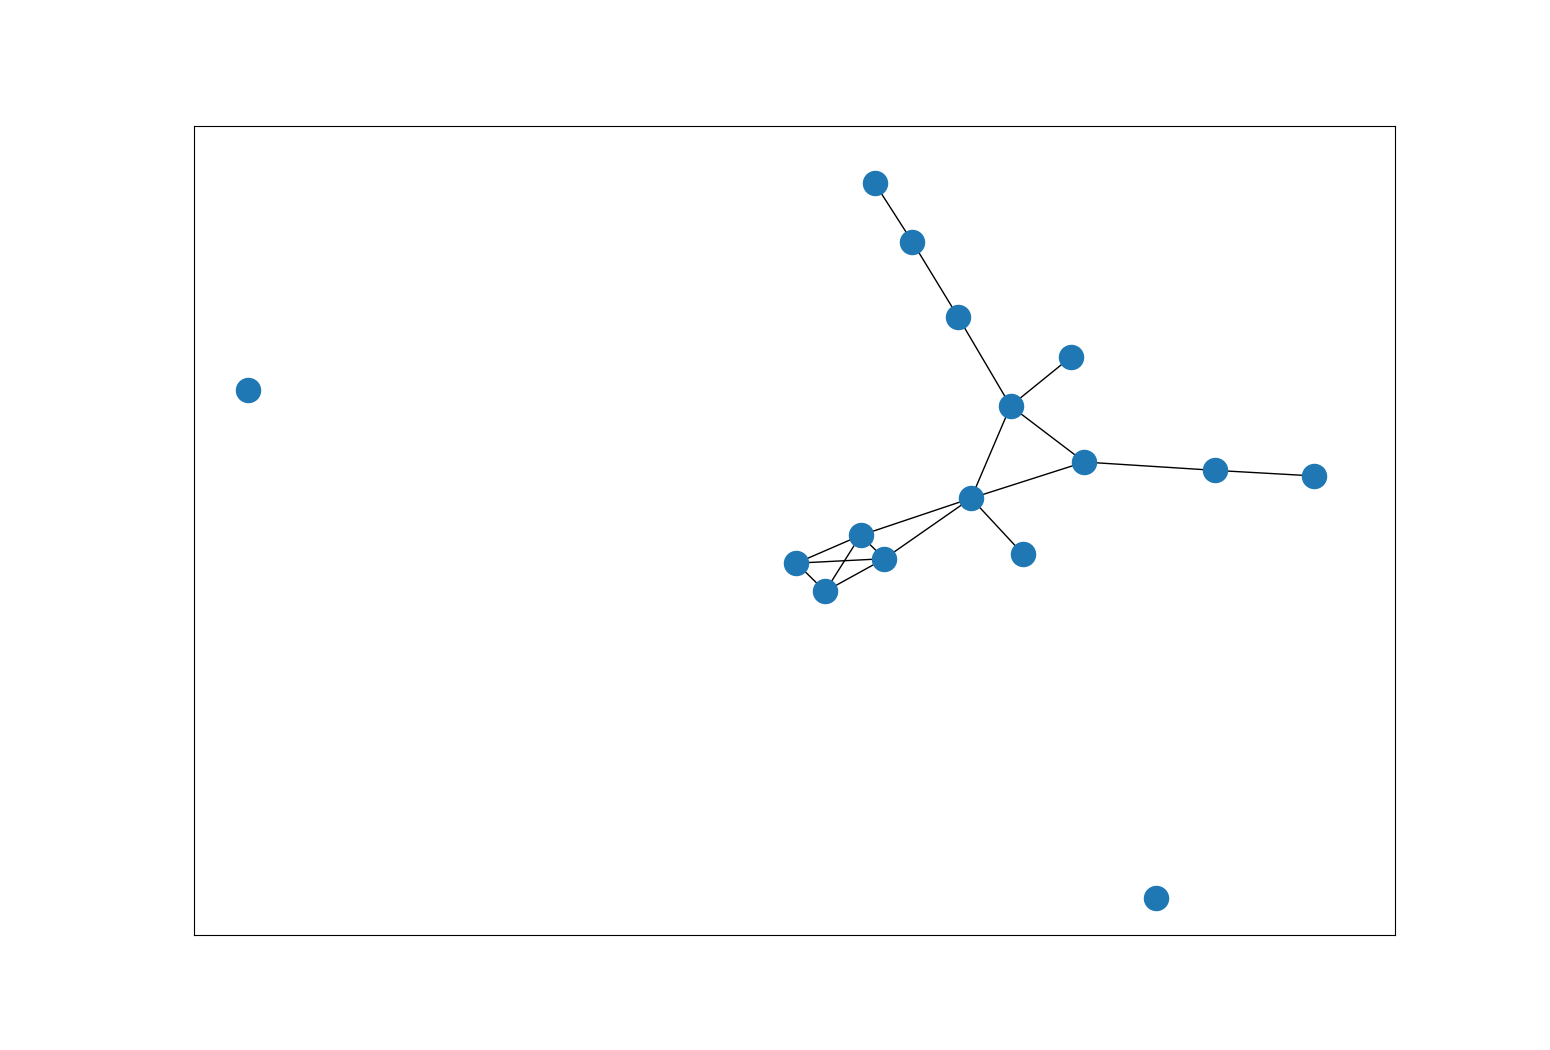

In [82]:
%matplotlib ipympl
# # Graph initialization
graph = nx.Graph()
# G.add_nodes_from([1, 2, 3, 4, 5, 6, 7, 8, 9])
# G.add_edges_from([(1,2), (3,4), (2,5), (4,5), (6,7), (8,9), (4,7), (1,7), (3,5), (2,7), (5,8), (2,9), (5,7)])
nodes = list(G.nodes())
edges = list(G.edges())
# Animation funciton
pos = nx.spring_layout(G)
def animate(i):
    colors = ['r', 'b', 'g', 'y', 'w', 'm']*len(nodes)
    # nx.draw_networkx(G, node_color=[random.choice(colors) for j in range(16)], with_labels=False)
    graph.add_nodes_from(edges[i],node_color=[random.choice(colors) for j in range(29)],Position=(random.randrange(0, 10), random.randrange(0, 10)))
    
    nx.draw_networkx(graph,with_labels=True, pos=pos)


nx.draw_networkx(G,with_labels=False)
fig = plt.gcf()
fig.set_size_inches(15.5, 10.5)
# Animator call
anim = animation.FuncAnimation(fig, animate, frames=15, interval=200 ,repeat=False, cache_frame_data = False)

In [83]:
HTML(anim.to_html5_video())

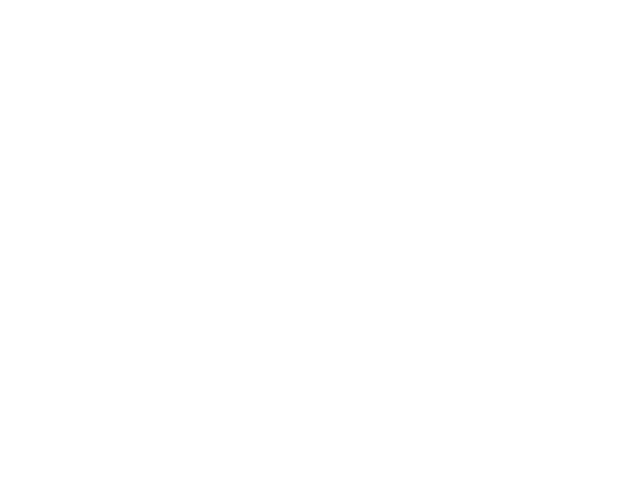

In [36]:
%matplotlib ipympl

# Animation funciton
def animate(i):
    colors = ['r', 'b', 'g', 'y', 'w', 'm']
    nx.draw_networkx(G, node_color=[random.choice(colors) for j in range(29)])

# nx.draw_circular(G)
fig = plt.gcf()

# Animator call
anim = animation.FuncAnimation(fig, animate, frames=1, interval=9000, blit=False ,repeat=False, cache_frame_data = False, )